# ML Training in SageMaker

The model used for this notebook is a basic Convolutional Neural Network (CNN).  
We'll train the CNN to classify images using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a well-known computer vision dataset.

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)

## Sequence of demo
#### Training is done in the following order:
1. Build development environment
2. Prepare input data
3. Modify SOTA training code (input data, output model)
4. Test training code
5. Run training job
6. Monitoring (job status, log etc)
7. Deploy saved models

## 1. Build development environment

### Set up the Notebook environment
We will use SageMaker studio as our development environment for the demonstration.  
Training script for demo is based on `Pytorch` framework.
So, before start the demo, we have to set the instance spec and kernel gateway image.
- instance spec: ml.g4dn.xlarge (4vCPU + 16GB + 1GPU)
- kernel image: PyTorch 1.6 Python 3.6 GPU Optimized

## 2. Prepare input data

### Download the CIFAR-10 dataset

I prepared `get_cifar10.py` file which download cifar10 dataset and convert to pytorch `DataLoader` type.  
I have previously downloaded the data in the `./data` directory.

In [1]:
from get_cifar10 import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


### Data preview

[2021-06-23 10:56:18.854 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:1933 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-23 10:56:18.889 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:1933 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
     ship     plane      deer       cat


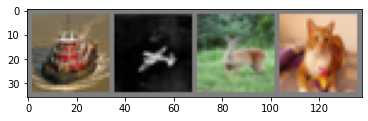

In [2]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

### Save the dataset in S3

We will save our datasets to object storage (S3 bucket).  
After a training job is created, the data will be loaded through the bucket url in the job.

In [4]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="data", 
                                       bucket=sagemaker_session.default_bucket(), 
                                       key_prefix="data/cifar10")

print(inputs)

s3://sagemaker-ap-northeast-2-834160605896/data/cifar10


## 3. Modify SOTA code

### Prepared SOTA code
```
source
├── my_cnn.py    # CNN Model network code
└── train.py     # training and evaluation code
```

In [5]:
!diff source/train.py source/train_sagemaker.py

15a16,20
> try:
>     from sagemaker_inference import environment
> except:
>     from sagemaker_training import environment
> 
105a111,123
>     
> 
> ### Inference Code
> def model_fn(model_dir):
>     device = "cuda" if torch.cuda.is_available() else "cpu"
>     model = Model()
>     if torch.cuda.device_count() > 1:
>         logger.info("Gpu count: {}".format(torch.cuda.device_count()))
>         model = nn.DataParallel(model)
> 
>     with open(os.path.join(model_dir, "model.pth"), "rb") as f:
>         model.load_state_dict(torch.load(f))
>     return model.to(device)
117,118c135,137
<     parser.add_argument("--model-dir", type=str, default='.')
<     parser.add_argument("--data-dir", type=str, default='./data')
---
>     env = environment.Environment()
>     parser.add_argument("--model-dir", type=str, default=env.model_dir)
>     parser.add_argument("--data-dir", type=str, default=env.channel_input_dirs.get("training"))


### What to modify

- In order to receive the specified data when creating a job, modify the **input data path** to the environment variable created by sagemaker.
- In order to register the output model after finish job, modify the **model saving path** to the environment variable created by sagemaker.

> There are more environment variable that provided by sagemaker. [Environment variables guide](https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md)

- To deploy the model, create a `model_fn` function to load the model in advance.

> This function is not invoked in our training code, it will be invoked when model is deployed.

## 4. Test training code

After code modification, user should check whether the code actually working.  
For the test, I will create a training job with 1 epoch.

### Define training job spec
In SageMaker, user can create training job through `sagemaker` python SDK.  
There is `Estimator` object which is concept of the job definition.

SageMaker provide various type of `Estimator`.
- Scikit-learn, Spark ML, XGBoost, Tensorflow, Keras, Pytorch, MXNet, Chainer

`Estimator` object will receive job spec as parameter.

In [6]:
from sagemaker.pytorch.estimator import PyTorch

instance_type = 'ml.p2.xlarge'

pytorch_estimator = PyTorch(
    # Job info
    role=sagemaker.get_execution_role(),
    base_job_name='06231855-cifar10-test',
    instance_count=1,
    instance_type=instance_type,
    # Framework info
    framework_version="1.7.1",
    py_version='py3',
    # Train script info
    source_dir='source',
    entry_point='train_sagemaker.py',
    hyperparameters = {'epochs': 1, 'lr': 0.01, 'batch': 64},
    metric_definitions=[
        {'Name': 'accuracy', 'Regex': 'Test Accuracy: (\S+)'}
    ]
)

### Run trianing job

We can start training job using `fit` method of `Estimator`.  
We can pass input data as parameter of `fit` method.

About training job in SageMaker:
- In SageMaker, training job is also kind of batch job using the container.
- Our trainig job will be based on container image that is pre-built by SageMaker.
- [Pre-built image list](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#general-framework-containers)

In [7]:
pytorch_estimator.fit(inputs, logs=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: 06231855-cifar10-test-2021-06-23-10-57-37-031



2021-06-23 10:57:37 Starting - Starting the training job
2021-06-23 10:57:39 Starting - Launching requested ML instances................
2021-06-23 10:59:03 Starting - Preparing the instances for training............
2021-06-23 11:00:13 Downloading - Downloading input data.....
2021-06-23 11:00:39 Training - Downloading the training image...........................................................
2021-06-23 11:05:41 Training - Training image download completed. Training in progress.......
2021-06-23 11:06:17 Uploading - Uploading generated training model.
2021-06-23 11:06:27 Completed - Training job completed


### View the created training job

https://ap-northeast-2.console.aws.amazon.com/sagemaker/home?region=ap-northeast-2#/jobs

### Local mode
When testing for operation check, if you create a job every time, it takes a long time for the job to run.  
So code verification takes a long time.  

For faster testing, users can run the test in the thier local environment.  
To train in `Local Mode`, it is necessary to have `docker-compose` or `nvidia-docker-compose` (for GPU) installed in the development environment.

## 5. Run training job

After confirming the job, and create a job again with desired epochs and desired GPU instance spec.

In [ ]:
from sagemaker.pytorch.estimator import PyTorch

instance_type = 'ml.p3.2xlarge'

pytorch_estimator = PyTorch(
    source_dir='source',
    entry_point='train_sagemaker.py',
    framework_version="1.7.1",
    py_version='py3',
    role=sagemaker.get_execution_role(),
    base_job_name='06231930-cifar10-train',
    instance_count=1,
    instance_type=instance_type,
    hyperparameters = {'epochs': 10, 'lr': 0.01, 'batch': 64},
    metric_definitions=[
        {'Name': 'accuracy', 'Regex': 'Test Accuracy: (\S+)'}
    ]
)

pytorch_estimator.fit(inputs, logs=False)

## 6. Monitor training

User can check the learning progress through the web or sdk.

Also, after training, user can check the metric results through the sagemaker sdk, and various analyzes are possible using sdk.

In [ ]:
sagemaker.analytics.TrainingJobAnalytics(pytorch_estimator._current_job_name, metric_names = ['accuracy']).dataframe()

# 6. Deploy saved models

### Deploy saved model
After a training, we can host the newly created model in SageMaker.

To create a SageMaker inference endpoint, we can call `deploy` method on a `PyTorch` Estimator.  
The deployed server runs a <U>SageMaker-provided PyTorch model server</U> and hosts the <U>model produced by our training script</U>.

After create inference endpoint, we can check the API url.

In [ ]:
cifar10_predictor = pytorch_estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: 06231855-cifar10-test-2021-06-23-11-06-31-141
INFO:sagemaker:Creating endpoint with name 06231855-cifar10-test-2021-06-23-11-06-31-141


----

### Invoke inference API

We can invoke inferece API by REST API.  
However, sagemaker sdk also provide interface to invoke API.

`deploy` returns a `Predictor` object, which we can use to do inference on the Endpoint hosting PyTorch model.  
Each Predictor provides a `predict` method which can do inference with numpy arrays or Python lists.  
Inference arrays or lists are serialized and sent to the PyTorch model server.

`predict` returns the result of inference against your model.  
By default, the inference result a NumPy array.

In [ ]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

### Delete endpoint

Hosted servers continue to run and are charged, so shut them down when not in use.

In [ ]:
# clean up
pytorch_estimator.delete_endpoint()